In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.metrics
import cv2
import pickle
import os, os.path
import importlib

import utils.sampletools as smpl

importlib.reload(smpl)

<module 'utils.sampletools' from 'd:\\Programming\\NClassifier\\dev_tests\\tf01_cnn_detect\\utils\\sampletools.py'>

In [2]:
def generate_batches_from_image_sample(image, sample, size_chain, batch_size, shuffle=True):
    mipimgs = smpl.generate_image_miplevels(image, size_chain)
    for s in smpl.shuffle_batches(sample, batch_size=batch_size, shuffle=shuffle):
        features = smpl.extract_features_from_samples_and_mipmaps(s, mipimgs)
        targets = smpl.extract_targets_from_samples(s)
        yield (features, targets)
        
def generate_batches_from_file(path, fname, batch_size, shuffle=True):
    with open(os.path.join(path,fname), 'rb') as f:
        sample, size_chain, img_fname = pickle.load(f)
    image = cv2.cvtColor(cv2.imread(os.path.join(path,img_fname)), cv2.COLOR_BGR2RGB)
    for s in generate_batches_from_image_sample(image, sample, size_chain, batch_size, shuffle=shuffle):
        yield s
        
def score_file(path, fname, batch_size, calc_fun):
    res = []
    for (x, y) in generate_batches_from_file(path, fname, batch_size, shuffle=False):
        res.append(calc_fun(x))
    return np.hstack(res)

In [3]:
tf.reset_default_graph()

tf_input = tf.placeholder(shape=(None,16,16,3),dtype=tf.float32)
tf_labels = tf.placeholder(shape=(None,1),dtype=tf.float32)

tf_y = tf.concat([tf_labels, 1-tf_labels], axis=1)

tf_z0 = tf.layers.max_pooling2d(tf.layers.conv2d(tf_input, 10, [3, 3], activation=tf.nn.elu), [2, 2], [2, 2])
tf_z1 = tf.layers.max_pooling2d(tf.layers.conv2d(tf_z0, 20, [3, 3], activation=tf.nn.elu), [2, 2], [2, 2])

tf_z2 = tf.reshape(tf_z1, shape=(-1, 80))

tf_z3 = tf.layers.dense(tf_z2, 10, activation=tf.nn.elu)
tf_z = tf.layers.dense(tf_z3, 2)

tf_p = tf.nn.softmax(tf_z)

tf_loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_y, logits=tf_z)
tf_train = tf.train.AdamOptimizer(1e-3).minimize(tf_loss)
#99.9+ gini

In [4]:
num_epochs = 20
path = '../../dev_datasets/faceimages/'
train_names = ['20171222_163619.pickle', '20171222_163630.pickle', '20171222_163727.pickle']
calc_names = ['20171222_163619.pickle', '20171222_163630.pickle', '20171222_163631.pickle', '20171222_163636.pickle', '20171222_163720.pickle', '20171222_163727.pickle']
batch_size = 1024
calc_batch_size = 16384

result_p = dict()

with tf.Session() as tfs:
    tfs.run(tf.global_variables_initializer())    
    for i in range(num_epochs):
        res_p = []
        res_y = []
        for fname in train_names:
            for (x, y) in generate_batches_from_file(path, fname, batch_size):
                tx = x / 255.0 - 0.5
                tf_train.run(feed_dict={tf_input: tx, tf_labels: y.reshape(-1, 1)})
                tp = tf_p.eval(feed_dict={tf_input: tx})[:,0]
                res_p.append(tp)
                res_y.append(y)
        full_p = np.hstack(res_p)
        full_y = np.hstack(res_y)
        print('step {0}, gini={1:.3f}'.format(i, sklearn.metrics.roc_auc_score(full_y>0.5, full_p)*2-1))   
        
    for fname in calc_names:
        result_p[fname] = score_file(path, fname, calc_batch_size, lambda x: tf_p.eval(feed_dict={tf_input: x / 255.0 - 0.5})[:,0])

step 0, gini=0.594
step 1, gini=0.882
step 2, gini=0.951
step 3, gini=0.969
step 4, gini=0.975
step 5, gini=0.978
step 6, gini=0.981
step 7, gini=0.984
step 8, gini=0.985
step 9, gini=0.985
step 10, gini=0.987
step 11, gini=0.988
step 12, gini=0.989
step 13, gini=0.989
step 14, gini=0.990
step 15, gini=0.991
step 16, gini=0.992
step 17, gini=0.991
step 18, gini=0.993
step 19, gini=0.993


In [5]:
def generate_prediction_map_2d(samples, probs):
    num_dim = len(samples[0]) >> 1
    mins = np.array([np.min([s[i * 2] for s in samples]) for i in range(num_dim)])
    maxs = np.array([np.max([s[i * 2 + 1] for s in samples]) for i in range(num_dim)])
    dims = maxs - mins
    
    sums = np.zeros(dims)
    cnts = np.zeros(dims)
    
    for (s,p) in zip(samples, probs):
        sums[s[0]:s[1],s[2]:s[3]] += p
        cnts[s[0]:s[1],s[2]:s[3]] += 1
        
    return sums / cnts

def generate_all_prediction_maps_2d(samples, probs):
    def select_level(index):
        ps = [probs[i] for i in range(len(samples)) if samples[i][0]==index]
        return [s[1:] for s in samples if s[0] == index], ps
    min_ind = min([s[0] for s in samples])
    max_ind = max([s[0] for s in samples])
    return [generate_prediction_map_2d(*select_level(i)) for i in range(min_ind, max_ind+1)]

def combine_prediction(path, fname, probs):
    with open(os.path.join(path,fname), 'rb') as f:
        sample, size_chain, img_fname = pickle.load(f)
    targets = smpl.extract_targets_from_samples(sample)
    gini = 0
    if any(targets>0.5):
        gini = sklearn.metrics.roc_auc_score((targets>0.5)*1, probs) * 2 - 1
    return (generate_all_prediction_maps_2d(sample, probs), gini)

Result for 20171222_163619.pickle is 0.923 gini
0.6296348761534318


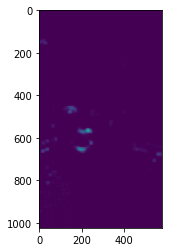

0.44198716754908673


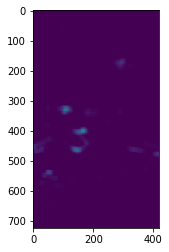

0.42017980162220925


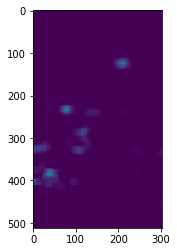

0.5778032063527938


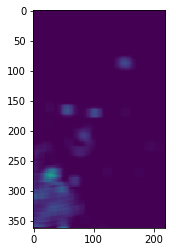

0.46265710652471626


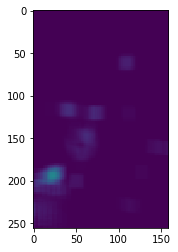

0.21923961455353386


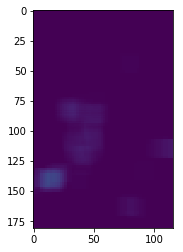

0.25056191716703324


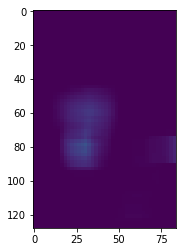

0.21196859488554765


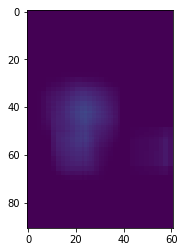

0.1639696647146387


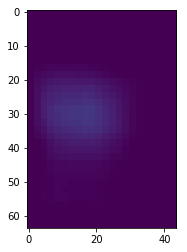

0.12176523132305661


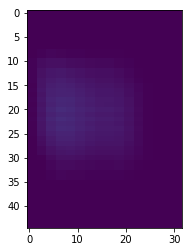

Result for 20171222_163630.pickle is 0.934 gini
0.6385621607769281


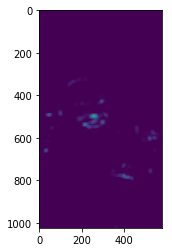

0.4701712788082659


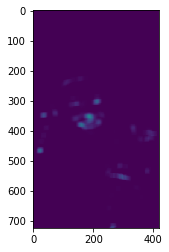

0.3931067109951982


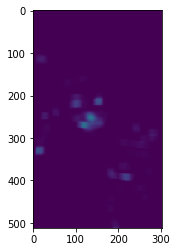

0.3119035395793617


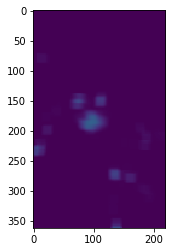

0.3466738745919429


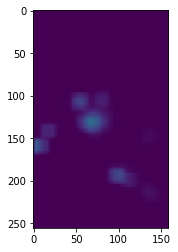

0.31361380557063967


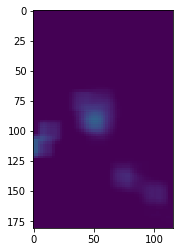

0.48899078369140625


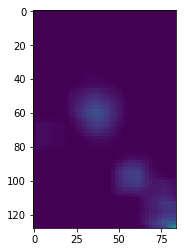

0.3750087767839432


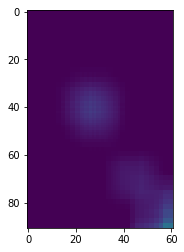

0.10197676331736147


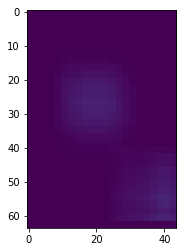

0.013050507005215196


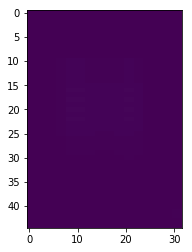

Result for 20171222_163631.pickle is 0.941 gini
0.5651363763026893


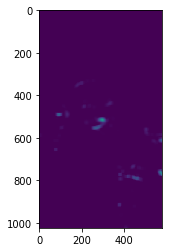

0.5093146269209683


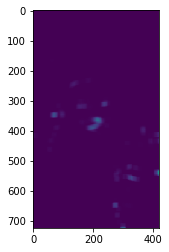

0.26943403750192374


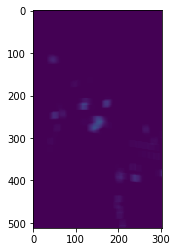

0.24850173724189517


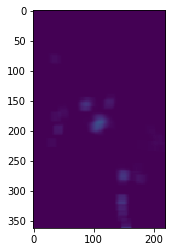

0.2196449257316999


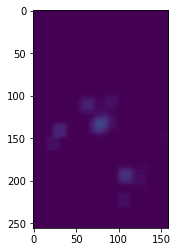

0.16202512495510746


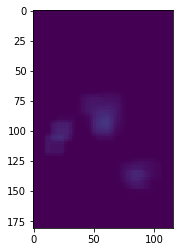

0.17272317880269838


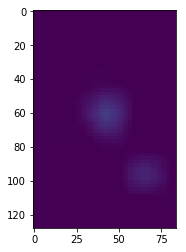

0.1550095693573894


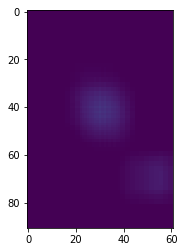

0.10105361468140828


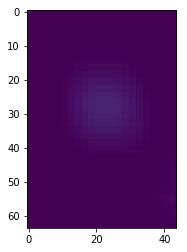

0.02011720288112855


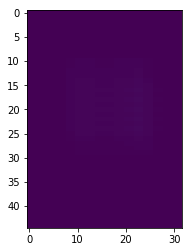

Result for 20171222_163636.pickle is 0.947 gini
0.5302762219216675


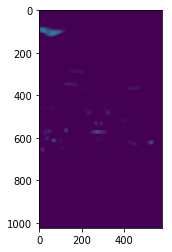

0.3642453363621219


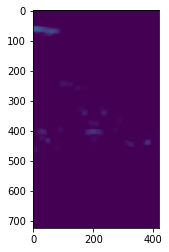

0.13532046681757492


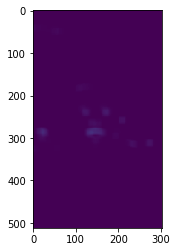

0.1439993302919902


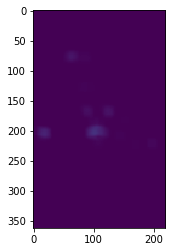

0.14651188343850663


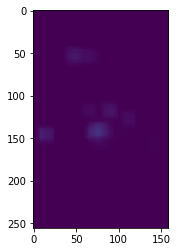

0.1020677961050751


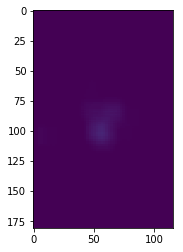

0.11696007044520229


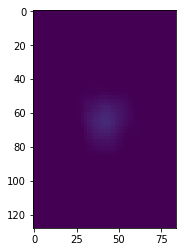

0.12227209940101602


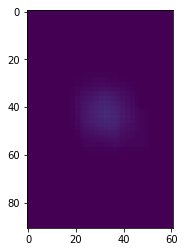

0.10246464881926176


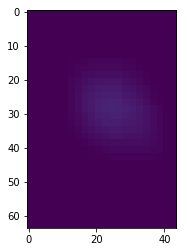

0.05643681447054405


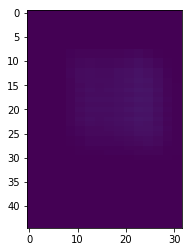

Result for 20171222_163720.pickle is 0.000 gini
0.5622786819003522


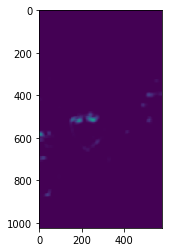

0.4392182375304401


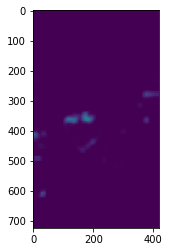

0.4627064517699182


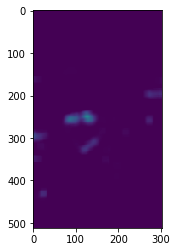

0.3428296521306038


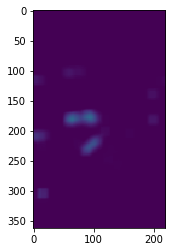

0.3620453296048822


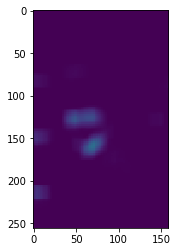

0.396574441050916


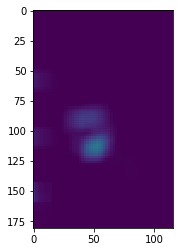

0.4218868092220873


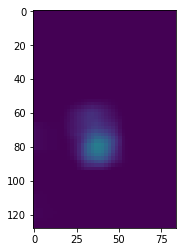

0.4204810543669737


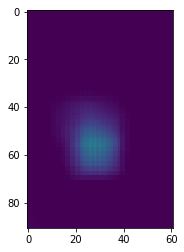

0.2724767083521442


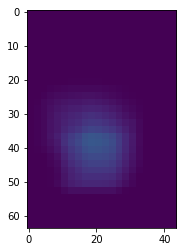

0.27441825472521586


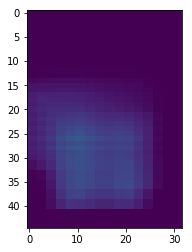

Result for 20171222_163727.pickle is 0.998 gini
0.656214143440593


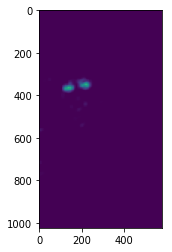

0.7045790175907314


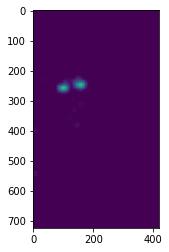

0.568575301207602


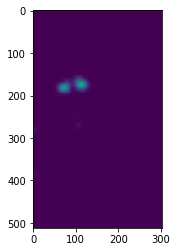

0.41111949854530394


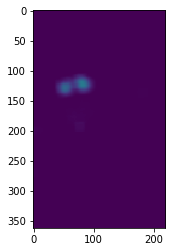

0.26269822103495244


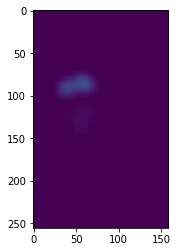

0.17906307812336308


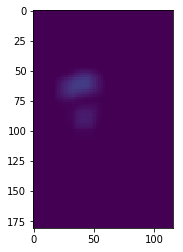

0.15653698650567094


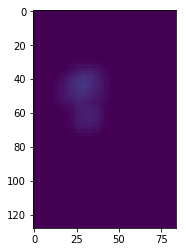

0.1346198182181979


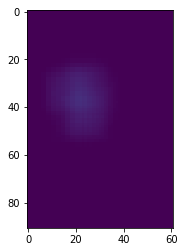

0.12597890359385083


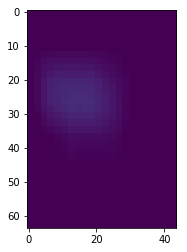

0.11649661752198881


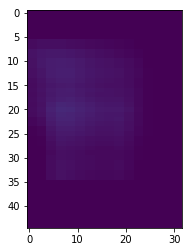

In [6]:
for fname in calc_names:
    pmaps, gini = combine_prediction(path, fname, result_p[fname])
    print('Result for {0} is {1:.3f} gini'.format(fname, gini))
    for pmap in pmaps:
        print(np.max(pmap))
        plt.imshow(pmap.transpose(), vmin=0, vmax=1)
        plt.show()

In [65]:
sklearn.metrics.roc_auc_score(full_y>0.5, full_p)*2-1

0.9805319656469242

In [60]:
full_y.mean()
full_p.mean()

0.038236156